## 1. Introduction

Traitement du langage naturel (NLP): La discipline de l’informatique, de l’intelligence artificielle et de la linguistique qui s’intéresse à la création de modèles informatiques qui traitent et comprennent le langage naturel. Il s’agit notamment de faire comprendre à l’ordinateur le regroupement sémantique des mots (par exemple, chat et chien sont sémantiquement plus similaires que chat et cuillère), synthèse vocale, traduction linguistique et bien d’autres

Analyse des sentiments: C’est l’interprétation et la classification des émotions (positives, négatives et neutres) dans les données textuelles à l’aide de techniques d’analyse de texte. L’analyse des sentiments permet aux organisations d’identifier le sentiment du public à l’égard de certains mots ou sujets.

Dans ce notebook, nous allons développer un modèle d’analyse des sentiments pour classer un tweet comme positif ou négatif.

## 2. Importation de librairie

In [231]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

from nltk.stem import WordNetLemmatizer
from  nltk.stem import SnowballStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from  nltk.stem import SnowballStemmer

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model
import tensorflow.keras
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import tensorflow as tf

from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification

# Regular imports
import numpy as np
import pandas as pd
import math
import random
import re

# Tensorflow Import
import tensorflow as tf
import hub as hub
from tensorflow.keras import layers

# Bert Import for Tokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import bert
import bert_tokenizer as tokenization

## 3. Dataset

In [166]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1')
print("The shape of the original dataset is {}".format(data.shape))
data.head()

The shape of the original dataset is (1600000, 6)


,0,1,2,3,4,5
0,target,id,date,flag,user,text
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [167]:
# Check missing values
data.isnull().any()

0    False
1    False
2    False
3    False
4    False
5    False
dtype: bool

In [168]:
data.drop(0,0,inplace=True)

In [169]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'comment']
data.head()

,sentiment,id,date,query,user_id,comment
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [170]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)
data.head()

,sentiment,comment
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew


In [276]:
data['sentiment'].value_counts()

4    800000
0    668928
0    131071
Name: sentiment, dtype: int64

In [171]:
df_cleaned = data[['sentiment','comment']]

In [172]:
df_cleaned

,sentiment,comment
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [173]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 1 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  object
 1   comment    1599999 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


In [174]:
df_cleaned['sentiment']= df_cleaned['sentiment'].astype(int) 

In [175]:
df_cleaned['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

### 3.1 Distribution de la varible 'sentiment'

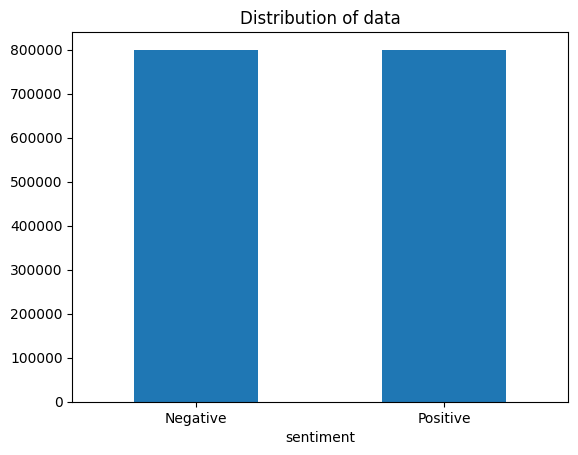

In [176]:
DATASET_COLUMNS  = ["sentiment"]
DATASET_ENCODING = "ISO-8859-1"

# Removing the unnecessary columns.
df_cleaned = df_cleaned[['sentiment','comment']]
# Replacing the values to ease understanding.
df_cleaned ['sentiment'] = df_cleaned ['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = df_cleaned.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
comment, sentiment = list(df_cleaned['comment']), list(df_cleaned['sentiment'])

In [177]:
df_cleaned = df_cleaned.sample(n=10000,
                frac=None,
                replace=False,
                weights=None,
                random_state=42,
                axis=None) 

In [178]:
df_cleaned['sentiment'].value_counts()

0    5004
1    4996
Name: sentiment, dtype: int64

## 4. Preprocess Text

Il transforme le texte pour les algorithmes d’apprentissage automatique fonctionne mieux.

Les étapes de prétraitement effectuées sont les suivantes :

Casse inférieure : chaque texte est converti en minuscules.

Remplacement des URL : Les liens commençant par « http » ou « https » ou « www » sont remplacés par « URL ».

Remplacement des emojis : remplacez les emojis en utilisant un dictionnaire prédéfini contenant des emojis ainsi que leur signification. (ex: « :) » à « EMOJIsmile »)

Remplacement des noms d’utilisateur : Remplacez @Usernames par le mot « UTILISATEUR ». (ex: « @Kaggle » à « UTILISATEUR »)

Suppression des non-alphabets : remplacement des caractères à l’exception des chiffres et des alphabets par un espace.

Removing Stopwords: : 3 lettres consécutives ou plus sont remplacées par 2 lettres. (ex: « hey » à « hey »)

Lemmatizing : les mots dont la longueur est inférieure à 2 sont supprimés.

In [179]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [180]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for comment in textdata:
        comment = comment.lower()
        
        # Replace all URls with 'URL'
        comment = re.sub(urlPattern,' URL',comment)
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = comment.replace(emoji, "EMOJI" + emojis[emoji])   
            
        # Replace @USERNAME to 'USER'.
        comment = re.sub(userPattern,' USER', comment)        
        # Replace all non alphabets.
        comment = re.sub(alphaPattern, " ", comment)
        # Replace 3 or more consecutive letters by 2 letter.
        comment = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in comment.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [181]:
import time
t = time.time()
processedtext = preprocess(comment)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 323 seconds


# 5. Analyse des données

Nous allons maintenant analyser les données prétraitées pour les comprendre. Nous allons tracer des nuages de mots pour les tweets positifs et négatifs à partir de notre ensemble de données et voir quels mots apparaissent le plus.

### 5.1. Word-Cloud for Negative comments

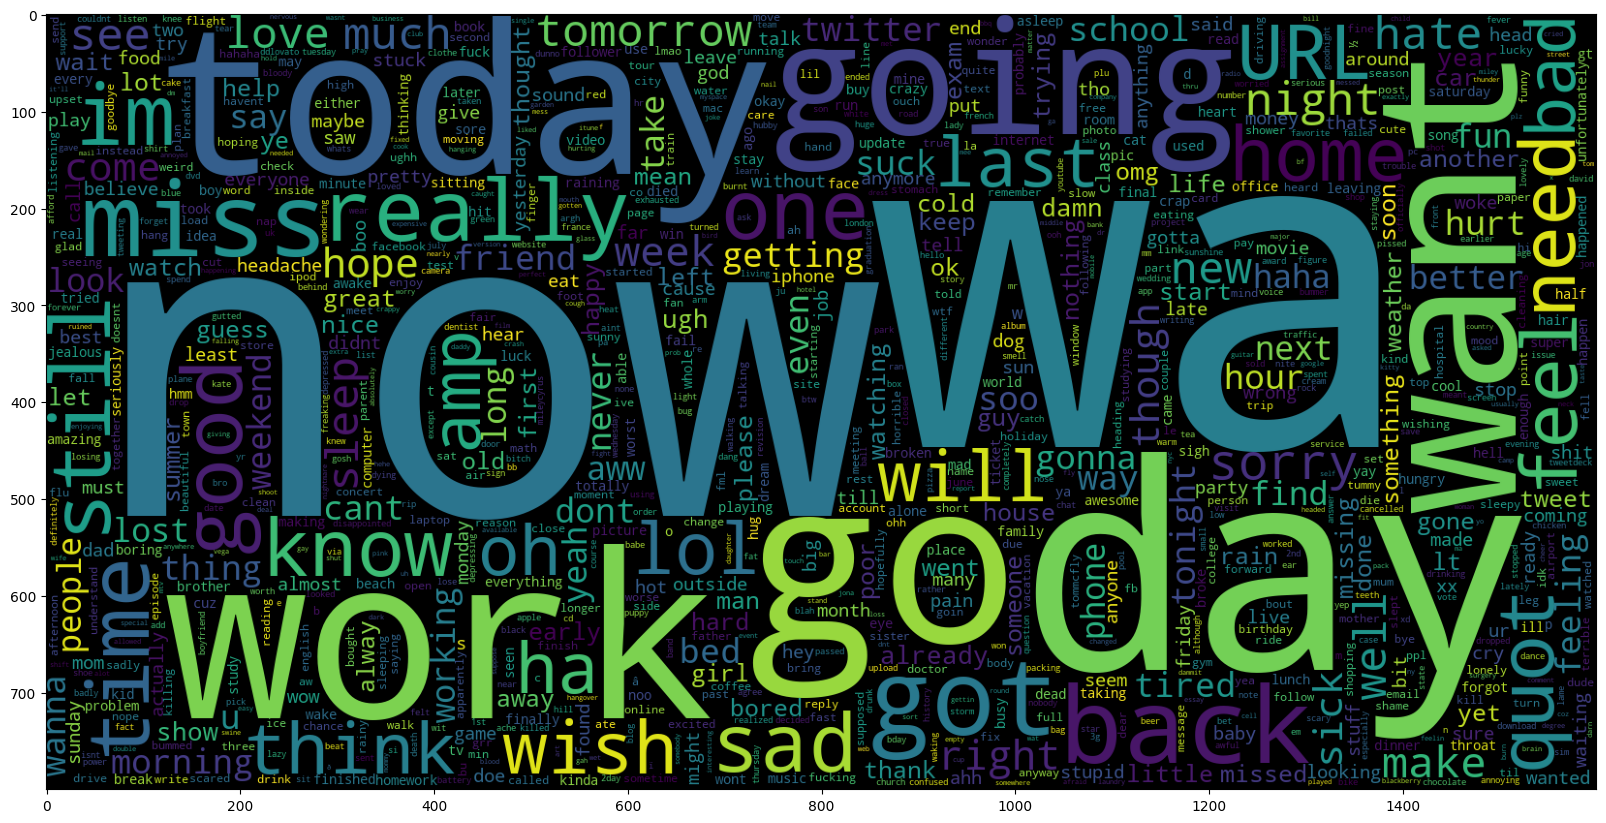

In [22]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### 5.2. Word-Cloud for Positive comments

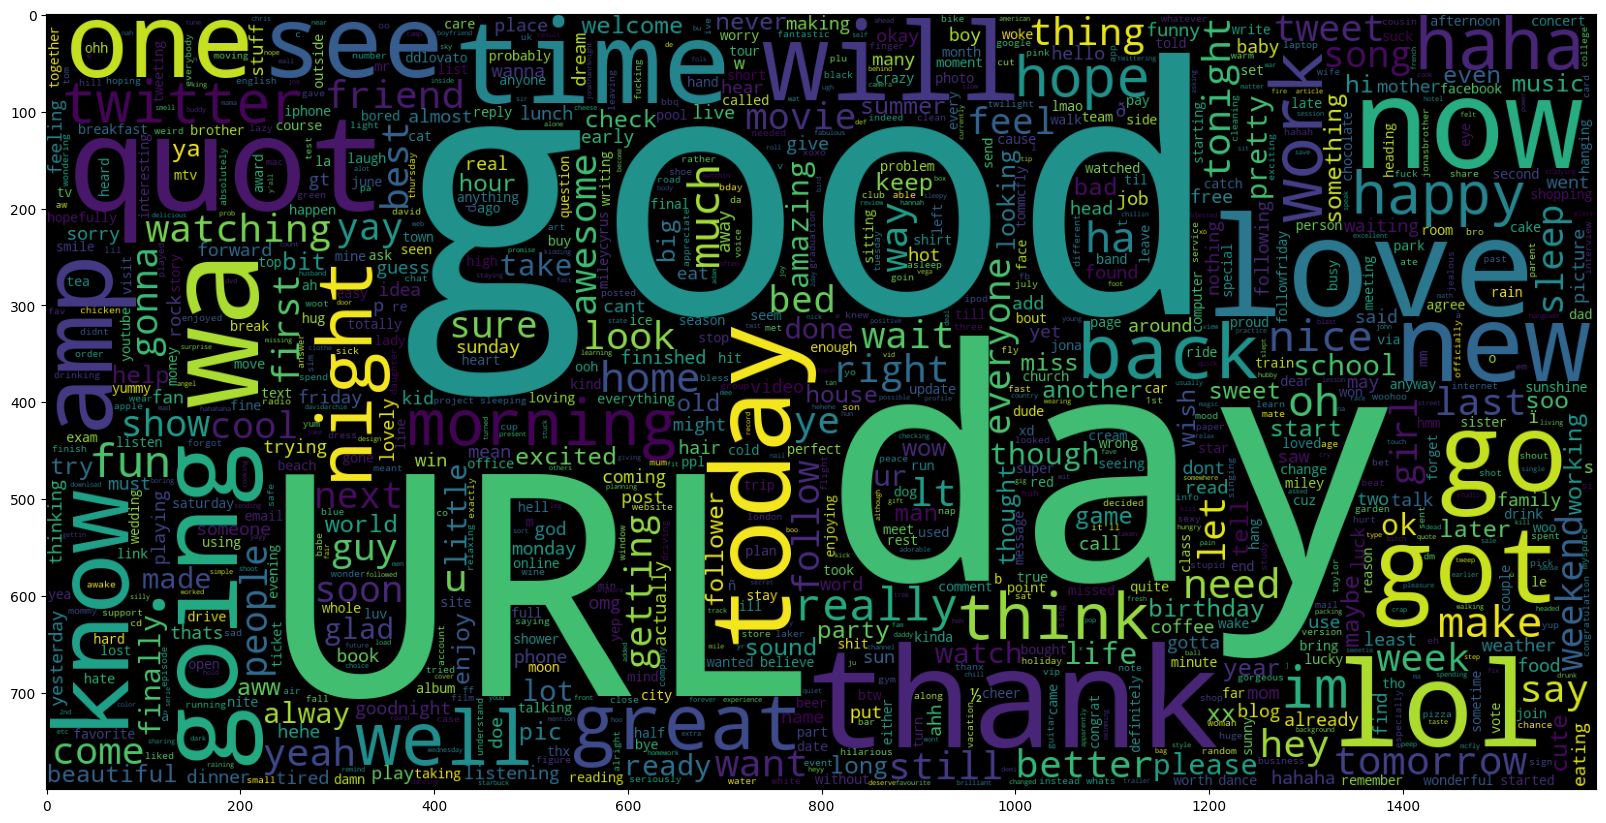

In [23]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## 6. Splitting the Data

Training Data : ensemble de données sur lequel le modèle serait formé. Contient 95 % de données.

Test Data: ensemble de données sur lequel le modèle serait testé. Contient 5 % de données.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## 7. Vectorisateur TF-IDF

TF-IDF indique quelle est l’importance du mot pour comprendre le document ou l’ensemble de données. 

TF-IDF Vectoriser convertit une collection de documents bruts en une matrice de fonctionnalités TF-IDF. Le vectorisateur est généralement entraîné uniquement sur le jeu de données X_train.

Ngram_range est la plage de mots dans une séquence. [Par exemple, « très cher » est un 2 grammes qui est considéré comme une caractéristique supplémentaire séparément de « très » et « cher » lorsque vous avez une gamme de n-gramme de (1,2)]

max_features spécifie le nombre d’entités à prendre en compte. [Ordonné par fréquence de caractéristique dans l’ensemble du corpus].

In [25]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


## 8. Transformation du jeu de données

Transformation de l’ensemble de données X_train et X_test en matrice des caractéristiques TF-IDF à l’aide du vectorisateur TF-IDF. Ces ensembles de données seront utilisés pour entraîner le modèle et le tester par rapport à celui-ci.

In [26]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


##  9. Création et évaluation de modèles

Nous créons  types de modèles différents pour notre problème d’analyse des sentiments :

Régression logistique 

Puisque notre ensemble de données n’est pas biaisé, c’est-à-dire qu’il a un nombre égal de prédictions positives et négatives. Nous choisissons l’exactitude comme mesure d’évaluation. De plus, nous traçons la matrice de confusion pour comprendre les performances de notre modèle sur les deux types de classification.

### 9.1. Logistic Regression Model

In [27]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39986
           1       0.82      0.83      0.83     40014

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



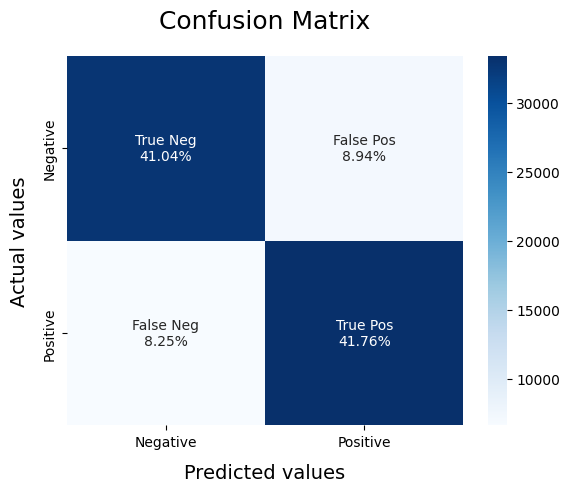

In [28]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

### 9.2. LSTM Model

In [300]:
X = df_cleaned['comment'].values
y = df_cleaned['sentiment'].values

In [301]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [302]:
tokenizer = Tokenizer(num_words=1500, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)
print("X_train Shape : ",X_train.shape)
print("y_train Shape : ",y_train.shape)
print("X_test Shape : ",X_test.shape)
print("y_test Shape : ",y_test.shape)

X_train Shape :  (7000, 40)
y_train Shape :  (7000,)
X_test Shape :  (3000, 40)
y_test Shape :  (3000,)


In [304]:
embed_dim = 128
lstm_out = 196
model1 = Sequential()
model1.add(Embedding(10018, embed_dim,input_length = X_train.shape[1]))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(3,activation='softmax'))
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 128)           1282304   
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_4 (Dense)             (None, 3)                 591       
                                                                 
Total params: 1,537,695
Trainable params: 1,537,695
Non-trainable params: 0
_________________________________________________________________


In [305]:
history = model1.fit(X_train, y_train,validation_data = (X_test,y_test),epochs = 5, batch_size=32)
yhat = model1.predict(X_test)

Epoch 1/5
219/219 [==============================] - 41s 163ms/step - loss: 0.6569 - accuracy: 0.6073 - val_loss: 0.5918 - val_accuracy: 0.6840
Epoch 2/5
219/219 [==============================] - 35s 161ms/step - loss: 0.5044 - accuracy: 0.7577 - val_loss: 0.5451 - val_accuracy: 0.7257
Epoch 3/5
219/219 [==============================] - 35s 161ms/step - loss: 0.4568 - accuracy: 0.7814 - val_loss: 0.5534 - val_accuracy: 0.7330
Epoch 4/5
219/219 [==============================] - 35s 161ms/step - loss: 0.4204 - accuracy: 0.8074 - val_loss: 0.5957 - val_accuracy: 0.7107
Epoch 5/5
219/219 [==============================] - 35s 158ms/step - loss: 0.3877 - accuracy: 0.8289 - val_loss: 0.6156 - val_accuracy: 0.7213


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


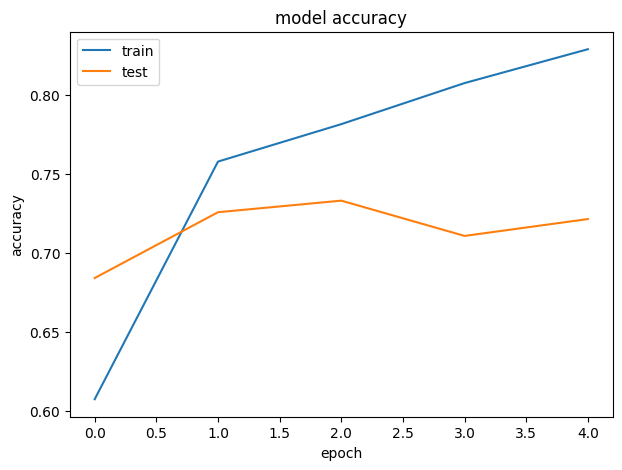

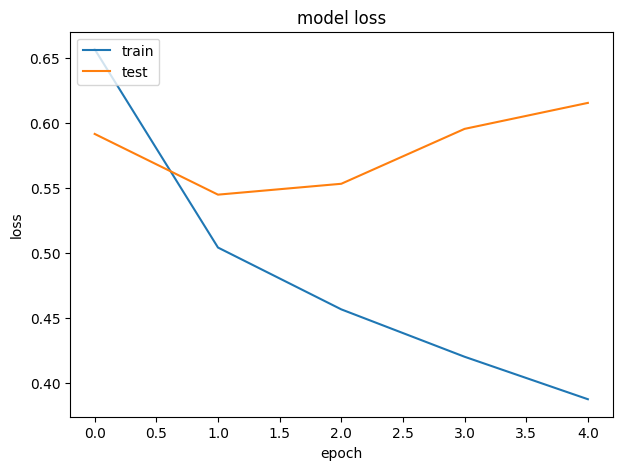

In [306]:
plt.figure(figsize = (7,5))
print(history.history.keys())
# Accuracy vs Epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss vs Epochs
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [308]:
score, acc = model1.evaluate(X_test,np.array(y_test),verbose=2,batch_size=128)

24/24 - 4s - loss: 0.6156 - accuracy: 0.7213 - 4s/epoch - 167ms/step


In [309]:
print ("Score : %.2f" %(score))
print ("Validation Accuracy : %.2f" %(acc))

Score : 0.62
Validation Accuracy : 0.72


### 9.3. LSTM  Model with Glove

In [38]:
def load_glove_model(glove_file):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model

In [39]:
glove_model = load_glove_model("glove.6B.50d.txt")

[INFO]Loading GloVe Model...
[INFO] Done...400000 words loaded!


In [40]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df_cleaned, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 8000
Test Data size 2000


In [41]:
tokenizer = Tokenizer()

In [42]:
tokenizer.fit_on_texts(train_data.comment)
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'for': 10, 'in': 11, 'of': 12, 'on': 13, 'so': 14, 'me': 15, 'have': 16, 'that': 17, 'but': 18, 'just': 19, "i'm": 20, 'at': 21, 'with': 22, 'was': 23, 'be': 24, 'not': 25, 'now': 26, 'good': 27, 'this': 28, 'up': 29, 'day': 30, 'all': 31, 'are': 32, 'out': 33, 'quot': 34, 'go': 35, 'no': 36, 'get': 37, 'like': 38, 'your': 39, 'http': 40, 'do': 41, "it's": 42, 'love': 43, 'work': 44, 'too': 45, 'today': 46, 'know': 47, 'got': 48, 'from': 49, 'going': 50, 'one': 51, 'lol': 52, 'time': 53, 'com': 54, "don't": 55, "can't": 56, 'what': 57, 'back': 58, 'will': 59, 'u': 60, 'about': 61, 'its': 62, 'new': 63, 'im': 64, 'we': 65, 'had': 66, 'really': 67, 'can': 68, 'am': 69, 'well': 70, 'want': 71, 'see': 72, 'amp': 73, 'still': 74, 'how': 75, 'there': 76, 'thanks': 77, '2': 78, 'if': 79, 'some': 80, 'night': 81, 'think': 82, 'oh': 83, 'when': 84, 'or': 85, 'much': 86, 'need': 87, 'more': 88, 'home': 89, 'they':

In [43]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 16351


In [44]:
# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.comment),maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.comment),maxlen = 30)

In [45]:
labels = ['Negative', 'Positive']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())
y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [46]:
embeddings_index = {}
# opening the downloaded glove embeddings file
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        # For each line file, the words are split and stored in a list
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [47]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 50))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [48]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,50,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

In [49]:
# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
# The Input layer 
sequence_input = Input(shape=(30,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)
# dropout and conv layer 
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
# Passed on to the LSTM layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# Passed on to activation layer to get final output
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
model.compile(optimizer=Adam(), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

In [51]:
training = model.fit(x_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
8/8 [==============================] - 10s 619ms/step - loss: 0.6888 - accuracy: 0.5306 - val_loss: 0.6784 - val_accuracy: 0.5690 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - 3s 404ms/step - loss: 0.6661 - accuracy: 0.5986 - val_loss: 0.6495 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - 3s 388ms/step - loss: 0.6521 - accuracy: 0.6260 - val_loss: 0.6397 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 4/10
8/8 [==============================] - 3s 378ms/step - loss: 0.6332 - accuracy: 0.6436 - val_loss: 0.6402 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 5/10
8/8 [==============================] - 3s 388ms/step - loss: 0.6295 - accuracy: 0.6530 - val_loss: 0.6249 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 6/10
8/8 [==============================] - 3s 427ms/step - loss: 0.6235 - accuracy: 0.6495 - val_loss: 0.6191 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 7/10
8/8 [==============================] - 4s 465ms/step - loss: 0.6101 - 

In [52]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"
scores = model.predict(x_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

1/1 [==============================] - 0s 458ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


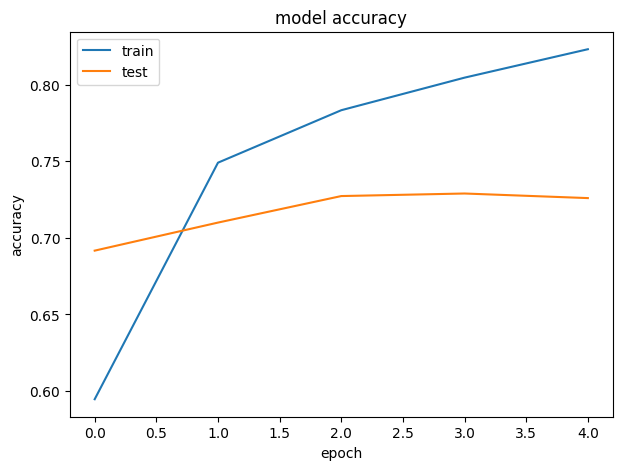

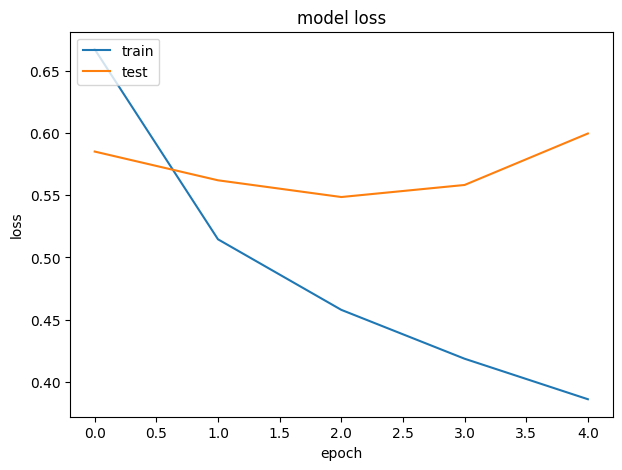

In [53]:
plt.figure(figsize = (7,5))
print(history.history.keys())
# Accuracy vs Epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss vs Epochs
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
score, acc = model.evaluate(x_test,np.array(y_test),verbose=2,batch_size=128)

16/16 - 0s - loss: 0.6010 - accuracy: 0.6775 - 438ms/epoch - 27ms/step


In [58]:
print ("Score : %.2f" %(score))
print ("Validation Accuracy : %.2f" %(acc))

Score : 0.60
Validation Accuracy : 0.68


### 9.4. BERT Model

In [273]:
# Load data from CSV
df = pd.read_csv(
    "training.1600000.processed.noemoticon.csv",
    names=["target", 'id', 'date', 'query', 'user_id', "text"],
    encoding="ISO-8859-1",
)

In [274]:
# Drop useless columns
df.drop(columns=['id', 'date', 'query', 'user_id'], inplace=False)

,target,text
0,target,text
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [279]:
df.drop(0,0,inplace=True)

In [280]:
df['target'].value_counts()

4    800000
0    668928
0    131071
Name: target, dtype: int64

In [281]:
# Replace target values with labels
df.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)

# And back to binary values
df.target.replace(
    {
        "NEGATIVE": 0,
        "POSITIVE": 1,
    },
    inplace=True,
)

In [282]:
# Sample data for development
TEXT_SAMPLE_SIZE = 10000  # <= 0 for all

# Sample data
if TEXT_SAMPLE_SIZE > 0:
    df = df.groupby("target", group_keys=False).apply(
        lambda x: x.sample(
            n=int(TEXT_SAMPLE_SIZE / df["target"].nunique()), random_state=42, replace=True
        )
    ).reset_index(drop=True)

In [283]:
df['target'].value_counts()

0    3333
1    3333
0    3333
Name: target, dtype: int64

In [284]:
# Bert Tokenizers
from transformers import BertTokenizerFast

BERT_MODEL = "bert-base-uncased"

In [285]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL, do_lower_case=True)

In [286]:
from tqdm import tqdm

input_ids = np.asarray([tokenizer(sent, padding="max_length", truncation=True)["input_ids"] for sent in tqdm(df.text)])
attention_mask = np.asarray([tokenizer(sent,padding="max_length",truncation=True)["attention_mask"] for sent in tqdm(df.text)])
token_type_ids = np.asarray([tokenizer(sent,padding="max_length",truncation=True)["token_type_ids"] for sent in tqdm(df.text)])

100%|██████████| 9999/9999 [00:04<00:00, 2087.38it/s]


In [287]:
from sklearn.model_selection import train_test_split

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   9999 non-null   object
 1   id       9999 non-null   object
 2   date     9999 non-null   object
 3   query    9999 non-null   object
 4   user_id  9999 non-null   object
 5   text     9999 non-null   object
dtypes: object(6)
memory usage: 468.8+ KB


In [289]:
df['target'].value_counts()

0    3333
1    3333
0    3333
Name: target, dtype: int64

In [290]:
df['target']= df['target'].astype(int) 

In [291]:
# Train-test split
(
    texts_train,
    texts_test,
    input_ids_train,
    input_ids_test,
    attention_mask_train,
    attention_mask_test,
    token_type_ids_train,
    token_type_ids_test,
    labels_train,
    labels_test,
) = train_test_split(
    df.text.values,
    input_ids,
    attention_mask,
    token_type_ids,
    df.target.values,
    test_size=0.2,
    stratify=df.target.values,
    random_state=42,
)

In [292]:
# # Define NN model
# print("Defining model...")
# model = TFBertForSequenceClassification.from_pretrained(
#     embed_dim,input_length = X_train.shape[1], BERT_MODEL, num_labels=2
# )

# Define NN model
print("Defining model...")
model = TFBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2

Defining model...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [293]:
# compile NN network
print("Compiling model...")
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=2e-5), # Value recommended by the Bert team
    metrics=BinaryAccuracy(),
)


Compiling model...


In [294]:
# fit NN model
print("Fitting model...")
model.fit(
    [input_ids_train, attention_mask_train, token_type_ids_train],
    labels_train,
    epochs=5,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=2),
    ],
    workers=4,
    use_multiprocessing=True,
)
print(model.summary())

Fitting model...
Epoch 1/5
800/800 [==============================] - 20664s 26s/step - loss: 0.7050 - binary_accuracy: 0.6513 - val_loss: 0.5670 - val_binary_accuracy: 0.7237
Epoch 2/5
800/800 [==============================] - 18488s 23s/step - loss: 0.6363 - binary_accuracy: 0.6618 - val_loss: 0.6140 - val_binary_accuracy: 0.6631
Epoch 3/5
800/800 [==============================] - 22166s 28s/step - loss: 0.6063 - binary_accuracy: 0.7164 - val_loss: 0.5740 - val_binary_accuracy: 0.7019
Model: "tf_bert_for_sequence_classification_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_684 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538   

In [295]:
# Get predictions
y_pred = model.predict([input_ids_test, attention_mask_test, token_type_ids_test])
y_pred_proba = [float(x[1]) for x in tf.nn.softmax(y_pred.logits)]
y_pred_label = [0 if x[0] > x[1] else 1 for x in tf.nn.softmax(y_pred.logits)]

In [296]:
# Evaluate the model
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

print("Confusion Matrix : ")
print(confusion_matrix(labels_test, y_pred_label))

Confusion Matrix : 
[[887 446]
 [137 530]]


In [297]:
print("ROC AUC score : ", round(roc_auc_score(labels_test, y_pred_proba), 3))

print("Average Precision score : ", round(average_precision_score(labels_test, y_pred_proba), 3))

ROC AUC score :  0.819
Average Precision score :  0.711


## 10. Enregistrement du modèle LSTM 

In [310]:
import joblib 
joblib.dump(model1, 'my_model.pkl.pkl')

INFO:tensorflow:Assets written to: ram://9bf5ee44-de8f-4854-92da-c543c5bf3bb9/assets


INFO:tensorflow:Assets written to: ram://9bf5ee44-de8f-4854-92da-c543c5bf3bb9/assets


['my_model.pkl.pkl']